# Unconditional Language Models (4.1 & 4.3)


*   STEP 1 TOKENIZE THE DATA
*   STEP 2 PREPROCESS INTO SMALLER SEQUENCES FOR TRAINING
*   STEP 3 TRAIN BASELINE GRU RNN TO PRODUCE TEXT
*   STEP 4 TRAIN GATED CNN WITH RESIDUAL
*   STEP 5 EVALUATE RESULTS (BLEU & UNIVERSAL COSINE SIMILARITY)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 0 // IMPORT OUR STUFF

In [ ]:
# !pip install numpy
import pandas as pd
import numpy as np
import ast
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import compress

import random
import sys
import io

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Masking, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Activation, Multiply, Flatten, BatchNormalization, Add
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax
from tensorflow.keras import activations

from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
data = pd.read_csv('/content/drive/My Drive/CS230/finaldata.csv')
train = pd.read_csv('/content/drive/My Drive/CS230/finaldata_train.csv')
test = pd.read_csv('/content/drive/My Drive/CS230/finaldata_test.csv')

In [ ]:
data.head(5).iloc[:, :10]

,genres,overview,title,vote_average,vote_count,length,num_genres,action,adventure,animation
0,"['animation', 'comedy', 'family']","Led by Woody, Andy's toys live happily in his ...",Toy Story,7.7,5415.0,50,3,0,0,1
1,"['adventure', 'fantasy', 'family']",When siblings Judy and Peter discover an encha...,Jumanji,6.9,2413.0,65,3,0,1,0
2,"['romance', 'comedy']",A family wedding reignites the ancient feud be...,Grumpier Old Men,6.5,92.0,57,2,0,0,0
3,['comedy'],Just when George Banks has recovered from his ...,Father of the Bride Part II,5.7,173.0,56,1,0,0,0
4,"['action', 'crime', 'drama', 'thriller']","Obsessive master thief, Neil McCauley leads a ...",Heat,7.7,1886.0,55,4,1,0,0


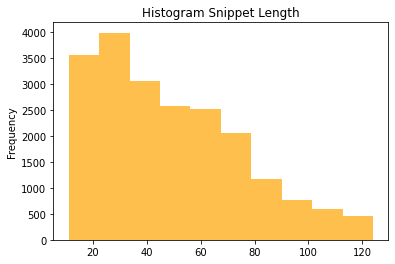

Average Snippet is:  48  words.


In [ ]:
# Reminder of the length of the snippets...
data['length'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Histogram Snippet Length')

plt.show()

print('Average Snippet is: ', int(np.mean(data.length)), ' words.')

## STEP1 // LET'S TOKENIZE THE DATA

In [ ]:
data['overview_stop']=['<START> '+a+' <END>' for a in data.overview_stop]
train['overview_stop']=['<START> '+a+' <END>' for a in train.overview_stop]
test['overview_stop']=['<START> '+a+' <END>' for a in test.overview_stop]

In [ ]:
# Tokenizing / Create a Tokenizer object

liststrings = list(data.overview_stop)
size_dict = 10000
tokenizer = Tokenizer(num_words= size_dict+1, 
                      filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n', 
                      split=' ', 
                      oov_token='<UNK>',
                      document_count=0)


tokenizer.fit_on_texts(liststrings) 
seqtokens = tokenizer.texts_to_sequences(liststrings)
traintokens = tokenizer.texts_to_sequences(list(train.overview_stop))
testtokens = tokenizer.texts_to_sequences(list(test.overview_stop))

tokenizer_config = tokenizer.get_config()
dict_counts = tokenizer_config['word_counts']
dict_index = tokenizer_config['word_index'] 

In [ ]:
tokenizer.sequences_to_texts(seqtokens)[:5] 

In [ ]:
sequnk = [[1 if x ==1 else 0 for x in s] for s in seqtokens]
count_unk = [np.sum(x) for x in sequnk]
freq_unk = [float(np.sum(x)/len(x)) for x in sequnk]

In [ ]:
# Reminder of the length of the snippets...
print('Average Number of <UNK>s is: ', np.round(np.mean(count_unk),1))
print('Max Number of <UNK>s is: ', np.round(np.max(count_unk),1))

print('Average Freq of <UNK>s is: ', np.round(np.mean(freq_unk),3))
print('Max Freq of <UNK>s is: ', np.round(np.max(freq_unk),3))

Average Number of <UNK>s is:  2.4
Max Number of <UNK>s is:  12
Average Freq of <UNK>s is:  0.041
Max Freq of <UNK>s is:  0.121


In [ ]:
lengths = [len(x) for x in seqtokens]
maxlen = max(lengths)
m = len(seqtokens)

In [ ]:
x = pad_sequences(seqtokens, maxlen=maxlen)

In [ ]:
y = np.array(data[['drama','comedy','thriller','romance','adventure','family']])

In [ ]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (20691, 136)
y shape:  (20691, 6)


In [ ]:
dict_index

##STEP2 // PRE-PROCESS INTO SMALLER SEQUENCES

In [ ]:
### WORD-LEVEL LANGUAGE MODEL WITH A FIXED WINDOW ###
# Script inspired in parts by the CHAR-LEVEL model: lstm_text_generation.py by fchollet https://github.com/keras-team/keras
# Adapted for this project by: ceciloge@stanford.edu

# Preprocess the text into smaller sequences of words on one side (window length), and output next word on the other
win_len = 10
#tokens = list(compress(seqtokens, drama_filter))
tokens = traintokens
x_rnn = []
y_rnn = []

for j, text in enumerate(tokens):
  if j%5000 == 0: print("We're at...", j)
  for i in range(len(text)-win_len):
    x_rnn.append(text[i:i+win_len])
    y_rnn.append(text[i+win_len])

print("Total number of smaller sequences: ", len(x_rnn))

We're at... 0
We're at... 5000
We're at... 10000
We're at... 15000
We're at... 20000
Total number of smaller sequences:  878744


In [ ]:
# Turning our sequences into arrays
x_rnn_array = np.array([np.array(s) for s in x_rnn])
y_rnn_array = np.array([np.array(s) for s in y_rnn])-1
print('x Shape: ',x_rnn_array.shape)
print('y Shape: ',y_rnn_array.shape)

x Shape:  (878744, 10)
y Shape:  (878744,)


##STEP3 // TRAIN A BASELINE RNN TO PRODUCE TEXT

In [ ]:
### RNN LANGUAGE MODEL ###
# By: ceciloge@stanford.edu

# Input & Embedding
seq_input = Input(shape=(win_len,), name = 'miniseq')
h = Embedding(size_dict+1, 64, input_length = win_len, mask_zero=True, name = 'embedding')(seq_input)

# Two GRU Layers
h = GRU(256, name = 'GRU1', return_sequences= True, kernel_initializer = 'glorot_normal')(h)
h = GRU(256, name = 'GRU2', kernel_initializer = 'glorot_normal')(h)

# Final Dense Layers
h = Dense(512, activation = 'relu', name = 'dense1')(h)
h = Dense(2560, activation = 'relu', name = 'dense2')(h)
next_word = Dense(size_dict, activation='linear', name = 'final')(h)

gen_model = Model(inputs = seq_input, outputs = next_word)
gen_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
miniseq (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 64)            640064    
_________________________________________________________________
GRU1 (GRU)                   (None, 10, 256)           247296    
_________________________________________________________________
GRU2 (GRU)                   (None, 256)               394752    
_________________________________________________________________
dense1 (Dense)               (None, 512)               131584    
_________________________________________________________________
dense2 (Dense)               (None, 2560)              1313280   
_________________________________________________________________
final (Dense)                (None, 10000)            

In [ ]:
# Functions to produce text with our RNN model

every = 5
end = tokenizer.texts_to_sequences([['<end>']])[0][0] 
start = tokenizer.texts_to_sequences([['<start>']])[0][0] 
dicke = tokenizer.texts_to_sequences([["dickens'"]])[0][0]

def sample(preds, greedy = False):
  # This first function samples the next word based on the output logits from the model
  preds = np.asarray(preds).astype('float64')
  #print(preds)
  preds[0] = np.min(preds) # Minimize prob of <UNK> from being generated as it is not useful
  preds[start-1] = np.min(preds) # Minimize prob of <start> from being generated as it is not useful
  preds[dicke-1] = np.min(preds) # Minimize prob of "dicken'" from being generated as it is not useful
  preds = preds-np.max(preds)
  preds = np.exp(preds)
  preds = preds/np.sum(preds)
  samp = np.random.multinomial(1, preds, 1)
  if greedy: 
    out = max(1, np.argmax(preds))
  else: 
    out = np.argmax(samp)
  return out+1

def generate_text(epoch, _):
  # This second function prints generated text at end of every few epochs
  if epoch%every == 0:
    print()
    input = '<start> when siblings judy and peter discover a board game'
    print('Seed: "' + input + '"')
    output = []
    x_in = np.array(tokenizer.texts_to_sequences([input])[0])
    i = -1
    count = 0
    while i != end and count < 35:     
      preds = gen_model.predict(x_in.reshape((1,x_in.shape[0])), verbose=0)[0]
      i = sample(preds)
      x_in = np.append(x_in[1:],i)
      output.append(i)
      count+=1
      
    print(input+" "+tokenizer.sequences_to_texts([output])[0])

# Defining our callbacks:
checkpoint = ModelCheckpoint(filepath='model',
                             frequency = "epoch",
                             save_weights_only = True,
                             verbose = 0)

gen_callback = LambdaCallback(on_epoch_end=generate_text)


In [ ]:
# Optimizer, Loss & Compiling
opt = Adamax(learning_rate=0.0001)
loss = SparseCategoricalCrossentropy(from_logits=True, name='sparse_cce')
gen_model.compile(loss=loss, optimizer=opt)
print('Ready!')

Ready!


In [ ]:
gen_model.load_weights('/content/drive/My Drive/CS230/Models/baseline')

In [ ]:
# Let's train!
gen_model.fit(x_rnn_array, y_rnn_array,
          batch_size=256,
          epochs= 20,
          callbacks=[gen_callback, checkpoint],
          verbose = 1)

In [ ]:
gen_model.save_weights('/content/drive/My Drive/CS230/Models/baseline')

In [ ]:
gen_model.evaluate(x_rnn_array, y_rnn_array)

27461/27461 [==============================] - 116s 4ms/step - loss: 0.8327


0.8326650261878967

In [ ]:
# Let's choose several seeds:

string_seed0 = 'judy and peter discover a board game that will'
string_seed1 = 'CS230 students met a year ago for the'
string_seed2 = 'professor andrew is on a mission to' 
string_seed3 = 'professor andrew goes on an adventure to'
string_seed4 = 'CS230 students discover a'
string_seed5 = 'a group of friends decides to go out for'

def model_generate_text(model = gen_model, seed = string_seed1, length = 100, greedy = False, verbose = True, endtok = True):
    # This function generates text from a given seed - works like the callback function.
    input = '<START> '+seed
    output = []
    
    x_in = pad_sequences(tokenizer.texts_to_sequences([input]), maxlen=10)

    i = -1
    count = 0
    if endtok == True:
      while i != end and count <length:     
        preds = model.predict(x_in, verbose=0)[0]
        i = sample(preds, greedy=greedy)
        x_in = np.append(x_in[:,1:],i).reshape((1,10))
        output.append(i)
        count +=1
    else:
      while count <length:     
        preds = model.predict(x_in, verbose=0)[0]
        i = sample(preds, greedy=greedy)
        x_in = np.append(x_in[:,1:],i).reshape((1,10))
        output.append(i)
        count +=1
    if verbose: print(seed+" "+tokenizer.sequences_to_texts([output])[0])
    return str(seed+" "+tokenizer.sequences_to_texts([output])[0]), output

In [ ]:
# Now let's produce text with our fully trained model: 

#text0, output0 = model_generate_text(model = gen_model, seed = string_seed0, length = 65, greedy = True)
#text0, output0 = model_generate_text(model = gen_model, seed = string_seed0, length = 65, greedy = False)
print(20*"_"+" RANDOM " + 20*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model, seed = string_seed5, length = 50)
print(" ")
print(50*"_")
print(" ")
print(20*"_"+" GREEDY " + 20*"_")
print(" ")
text6, output6 = model_generate_text(model = gen_model, seed = string_seed1, length = 50, greedy = True)
text7, output7 = model_generate_text(model = gen_model, seed = string_seed2, length = 50, greedy = True)
text8, output8 = model_generate_text(model = gen_model, seed = string_seed3, length = 50, greedy = True)
text9, output9 = model_generate_text(model = gen_model, seed = string_seed4, length = 50, greedy = True)
text10, output10 = model_generate_text(model = gen_model, seed = string_seed5, length = 50, greedy = True)
print(" ")


____________________ RANDOM ____________________
 
CS230 students met a year ago for the role of a local farmer . <end>
professor andrew is on a mission to date a female new yorker whose long lost dad can be rescued . as he struggled to escape the stranger is determined to turn their kids away from him . the boy delivers strong children and the competition of his slow city featuring also numerous couples . three years later
professor andrew goes on an adventure to take his men away from his girlfriend's money and sells his ex lover mom martin more dollars high professional faith instead . but what if to build it is a cover individuals was haunting . intrigued against his exclusive gender disaster it is now as a murder he can revive
CS230 students discover a romantic battle – and skills for the french name of a science crew quickly foster isolated blood rooms . <end>
a group of friends decides to go out for their destination off to confront his own death legacy . <end>
 
_______________

##STEP 4 // TRAIN A GATED CNN WITH RESIDUAL

In [ ]:
### GATED CNN LANGUAGE MODEL ###
# Convolution Blocks consisting in: Conv1D with Gated Linear Unit 
# (Research: https://arxiv.org/abs/1612.08083 by Y. Dauphin)
# Idea adapted for this project by: ceciloge@stanford.edu

# Input & Embedding
seq_input = Input(shape=(win_len,), name = 'miniseq')
o0 = Embedding(size_dict+1, 64, input_length = win_len, mask_zero=True, name = 'embedding')(seq_input)

# Block 1
h1 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv11', kernel_initializer = 'glorot_normal')(o0)
h1 = BatchNormalization()(h1)
h2 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv12', kernel_initializer = 'glorot_normal')(o0)
h2 = BatchNormalization()(h2)
h2 = Activation(activations.sigmoid)(h2)
o1 = Multiply()([h1, h2])

# Block 2
h1 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv21', kernel_initializer = 'glorot_normal')(o1)
h1 = BatchNormalization()(h1)
h2 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv22', kernel_initializer = 'glorot_normal')(o1)
h2 = BatchNormalization()(h2)
h2 = Activation(activations.sigmoid)(h2)
o2 = Multiply()([h1, h2])

# Block 3
h1 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv31', kernel_initializer = 'glorot_normal')(o2)
h1 = BatchNormalization()(h1)
h2 = Conv1D(128, 4, strides=1, padding="causal", name ='Conv32', kernel_initializer = 'glorot_normal')(o2)
h2 = BatchNormalization()(h2)
h2 = Add()([o1, h2]) #Residual from Block1
h2 = Activation(activations.sigmoid)(h2)
o3 = Multiply()([h1, h2])

# Final Dense Layers
h = Dense(512, activation = 'relu', name = 'dense1', kernel_initializer = 'he_normal')(o3)
h = Dense(2560, activation = 'relu', name = 'dense2', kernel_initializer = 'he_normal')(h)
next_word = Dense(size_dict, activation='linear', name = 'final')(h)

gen_model2 = Model(inputs = seq_input, outputs = next_word[:,-1,:])
gen_model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
miniseq (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 64)       640064      miniseq[0][0]                    
__________________________________________________________________________________________________
Conv12 (Conv1D)                 (None, 10, 128)      32896       embedding[0][0]                  
__________________________________________________________________________________________________
Conv11 (Conv1D)                 (None, 10, 128)      32896       embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
# Functions to produce text with our Gated CNN model

every = 5

def generate_text2(epoch, _):
  # This second function prints generated text at end of every few epochs
  if epoch%every == 0:
    print()
    input = '<start> when siblings judy and peter discover a board game'
    print('Seed: "' + input + '"')
    output = []
    x_in = np.array(tokenizer.texts_to_sequences([input])[0])
    i = -1
    count = 0
    while i != end and count < 35:     
      preds = gen_model2.predict(x_in.reshape((1,x_in.shape[0])), verbose=0)[0]
      i = sample(preds)
      x_in = np.append(x_in[1:],i)
      output.append(i)
      count+=1
    print(input+" "+tokenizer.sequences_to_texts([output])[0])


# Defining our callbacks - reusing code from previous model:
checkpoint2 = ModelCheckpoint(filepath='model2',
                             frequency = "epoch",
                             save_weights_only = True,
                             verbose = 0)

gen_callback2 = LambdaCallback(on_epoch_end=generate_text2)

In [ ]:
opt = Adamax(learning_rate=0.0004)
loss = SparseCategoricalCrossentropy(from_logits=True, name='sparse_cce')
gen_model2.compile(loss=loss, optimizer=opt)
print('Ready!')

Ready!


In [ ]:
gen_model2.load_weights('/content/drive/My Drive/CS230/Models/gatedcnn')

In [ ]:
#Let's train!
gen_model2.fit(x_rnn_array, y_rnn_array,
          batch_size=256,
          epochs=5,
          callbacks=[gen_callback2, checkpoint2])

Epoch 1/5
3433/3433 [==============================] - ETA: 0s - loss: 3.7263
Seed: "<start> when siblings judy and peter discover a board game"
<start> when siblings judy and peter discover a board game of revenge with her run out world . <end>
3433/3433 [==============================] - 412s 120ms/step - loss: 3.7263
Epoch 2/5
3433/3433 [==============================] - 410s 119ms/step - loss: 3.7259
Epoch 3/5
3433/3433 [==============================] - 409s 119ms/step - loss: 3.7251
Epoch 4/5
3433/3433 [==============================] - 408s 119ms/step - loss: 3.7242
Epoch 5/5
3433/3433 [==============================] - 410s 119ms/step - loss: 3.7240


In [ ]:
gen_model2.save_weights('/content/drive/My Drive/CS230/Models/gatedcnn')

In [ ]:
gen_model2.evaluate(x_rnn_array, y_rnn_array)

In [ ]:
# Now let's produce text with our fully trained model:2  

print(20*"_"+" RANDOM " + 20*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model2, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model2, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model2, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model2, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model2, seed = string_seed5, length = 50)
print(" ")
print(50*"_")
print(" ")
print(20*"_"+" GREEDY " + 20*"_")
print(" ")
text6, output6 = model_generate_text(model = gen_model2, seed = string_seed1, length = 50, greedy = True)
text7, output7 = model_generate_text(model = gen_model2, seed = string_seed2, length = 50, greedy = True)
text8, output8 = model_generate_text(model = gen_model2, seed = string_seed3, length = 50, greedy = True)
text9, output9 = model_generate_text(model = gen_model2, seed = string_seed4, length = 50, greedy = True)
text10, output10 = model_generate_text(model = gen_model2, seed = string_seed5, length = 50, greedy = True)
print(" ")


____________________ RANDOM ____________________
 
CS230 students met a year ago for the murders . <end>
professor andrew is on a mission to save the accidents scramble to prove that . <end>
professor andrew goes on an adventure to impress the thrust who would be all about in it in his friendship <end>
CS230 students discover a pair of mysterious men in the middle of evil icon . <end>
a group of friends decides to go out for her wedding so to learn about pat is half people in action the other of the mob will finally find that her disastrous affections to a wheelchair but misses his she heads for the thrill at his room . <end>
 
__________________________________________________
 
____________________ GREEDY ____________________
 
CS230 students met a year ago for the most popular man in school . <end>
professor andrew is on a mission to find the truth about the world . <end>
professor andrew goes on an adventure to get up to the same family . <end>
CS230 students discover a new drug ro

## STEP 4 // EVALUATE RESULTS

In [ ]:
import tensorflow_hub as hub
univ_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# EVALUATE BLEU & COSINE SIMILARITY ON THE TEST SET

def cosine_sim(x,y):
    num = np.sum(x*y)
    den = np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2))
    return num/float(den)

def evaluate_gen(version, greedy = True):
  bleu = []
  sim = []
  fun = model_generate_text
  if version == 1: 
    model = gen_model
  else:
    model = gen_model2   
  
  for j, synopsis in enumerate(testtokens):
    #From test set:
    input = tokenizer.sequences_to_texts([synopsis[:10]])[0]
    output_test = synopsis[10:]
    output_test_string = tokenizer.sequences_to_texts([output_test])[0]
    output_test_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output_test]
    emb_test = univ_embed([output_test_string])
    l = len(synopsis)-10


    #From model:
    _, output = fun(model = model, seed = input, length = l, greedy = greedy, verbose = False, endtok = False)
    output_string = tokenizer.sequences_to_texts([output])[0]
    output_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output]
    emb = univ_embed([output_string])
    #Similarity Scores:
    b = sentence_bleu([output_test_list], output_list, smoothing_function=SmoothingFunction().method2)
    s = cosine_sim(emb, emb_test)

    if j%100 == 0: 
      print(j, " done!")
      #print("bleu: ", b)
      #print("sim: ", s)

    bleu.append(b)
    sim.append(s)
  
  bleu_score = np.mean(bleu)
  sim_score = np.mean(sim)
  print("BLEU: ", bleu_score)
  print("COS. SIMILARITY: ", sim_score)
  return bleu_score, sim_score

In [ ]:
print("RNN Performance:")
bleu_score_RNN, sim_score_RNN = evaluate_gen(1)

print("----------- RNN Performance -----------")
print("BLEU: ", np.round(bleu_score_RNN,4))
print("COS. SIMILARITY: ", np.round(sim_score_RNN,4))
print(" ")


RNN Performance:
----------- RNN Performance -----------
BLEU:  0.0637
COS. SIMILARITY:  0.2448
 


In [ ]:
print("Gated CNN Performance:")
bleu_score_CNN, sim_score_CNN = evaluate_gen(2)

print("-------- Gated CNN Performance --------")
print("BLEU: ", np.round(bleu_score_CNN,4))
print("COS. SIMILARITY: ", np.round(sim_score_CNN,4))

Gated CNN Performance:
-------- Gated CNN Performance --------
BLEU:  0.0714
COS. SIMILARITY:  0.2215
